# Load prerequisite libraries

In [1]:
import json

from matplotlib import pyplot
import seaborn

# Use tensorflow 2
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import models

# Custom libraries
import seq_utils
import resnet

# Load model

Here we load three models trained on different sets of chromosomes. We then make a model whose output is the average of the three individual models.

In [2]:
max_seq_len = 500

In [3]:
# Load models
chr_splits_idx = [0, 1, 2]
model_input = layers.Input(shape=(max_seq_len, 4))
model_list = []
model_outputs = []
for chr_split_idx in chr_splits_idx:
    print(f"Loading model {chr_split_idx}...")
    model_split = resnet.load_model(
        f'resnet_chr_split_{chr_split_idx}_w_mse_0.5_w_pearsonr_0.5_continued.h5'
    )
    model_split._name = f'model_chr_split_{chr_split_idx}'
    model_list.append(model_split)

    model_output = model_split(model_input)
    model_outputs.append(model_output)

# Model output: average of bs model outputs
model_avg_output = layers.Average()(model_outputs)

model_avg = models.Model(
    model_input,
    model_avg_output,
    )

model_avg

Loading model 0...
Loading model 1...
Loading model 2...


In [4]:
# Load output cell states
cell_states = json.load(open('model_outputs.json')) 
cell_states

['high cells',
 'deep cells(oblong)',
 'evl(oblong)',
 'ysl(dome)',
 'apoptosis like(dome)',
 'evl(dome)',
 'ectoderm(dome)',
 'dorsal margin(dome)',
 'non-dorsal margin(dome)',
 'ectoderm(30epi)',
 'evl(30epi)',
 'ysl(30epi)',
 'non-dorsal margin(30epi)',
 'dorsal margin(30epi)',
 'apoptosis like(30epi)',
 'dorsal posterior(50epi)',
 'dorsal ectoderm(50epi)',
 'ventral ectoderm(50epi)',
 'ventrolateral mesoendoderm(50epi)',
 'ysl(50epi)',
 'margin tail(50epi)',
 'apoptosis like(50epi)',
 'evl(50epi)',
 'dorsal anterior(50epi)',
 'ysl(shield)',
 'evl(shield)',
 'margin tail(shield)',
 'dorsal posterior(shield)',
 'dorsal ectoderm(shield)',
 'ventrolateral mesoderm(shield)',
 'endoderm(shield)',
 'ventral ectoderm(shield)',
 'dorsal anterior(shield)',
 'ysl(75epi)',
 'epidermis(75epi)',
 'psm(75epi)',
 'endoderm(75epi)',
 'evl(75epi)',
 'neural plate anterior(75epi)',
 'lateral plate mesoderm(75epi)',
 'prechordal plate(75epi)',
 'neural plate posterior(75epi)',
 'margin tail(75epi)',
 

# Test prediction output for a sequence

In [5]:
# Sequence to test
# More than one sequence can be tested at once
seqs = [
    'ACCGGTTTTTCTCGTCTTTTGAATGACAATGCGGCGACGCTCATACTTGAAATTCAAGTCTGAGCGTCGCCGGGCCATTGCGCAATGCCCCTCATTGCGCAATGGGCCCCTGTAATTGCGCAATGGCCTCAGGCGATTACGCAATCCCTTGTAATTGCGCAATGCGCCCCTCAATTGCGCATTCGAACTTGAATTTCATGTCTTTCGCGTTTCATTGCGACATCGCCGTGCATTGTCATTCAAATGGAAAGAGAAAGTCGAAAGACAAGAAGGGCAAGTGTCATACGCAATGGGCGACGCCGGGCTCATTGCGCAATGTCCCCCTGGGGGCTATTTCGCAAGATTGCGCAATAGTGGGACATTGCGCAATAGACGCCGGGGGGGTATTGCGCAATGCTCGCACGTAGCGCCGAGCGTCGCCATTGAAATGACAATGACCCCAGAAGGAGCGGCGGCGCCCTCGGATTGCGCAATCGGCGCCGCAACTGGAAAAACAGGAT',
]

In [6]:
# Convert to one-hot encoding
seqs_onehot = seq_utils.one_hot_encode(seqs, max_seq_len=max_seq_len)
seqs_onehot.shape

(1, 500, 4)

In [7]:
# Predict
# 95 predictions correspond to the log10 atac peak signal of each cell state
preds = model_avg.predict(seqs_onehot)
preds.shape

(1, 95)

C:\Users\casti\AppData\Local\Temp\ipykernel_33476\2423011157.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cell_states, rotation=90)


Text(0, 0.5, 'log10(ATAC peak signal)')

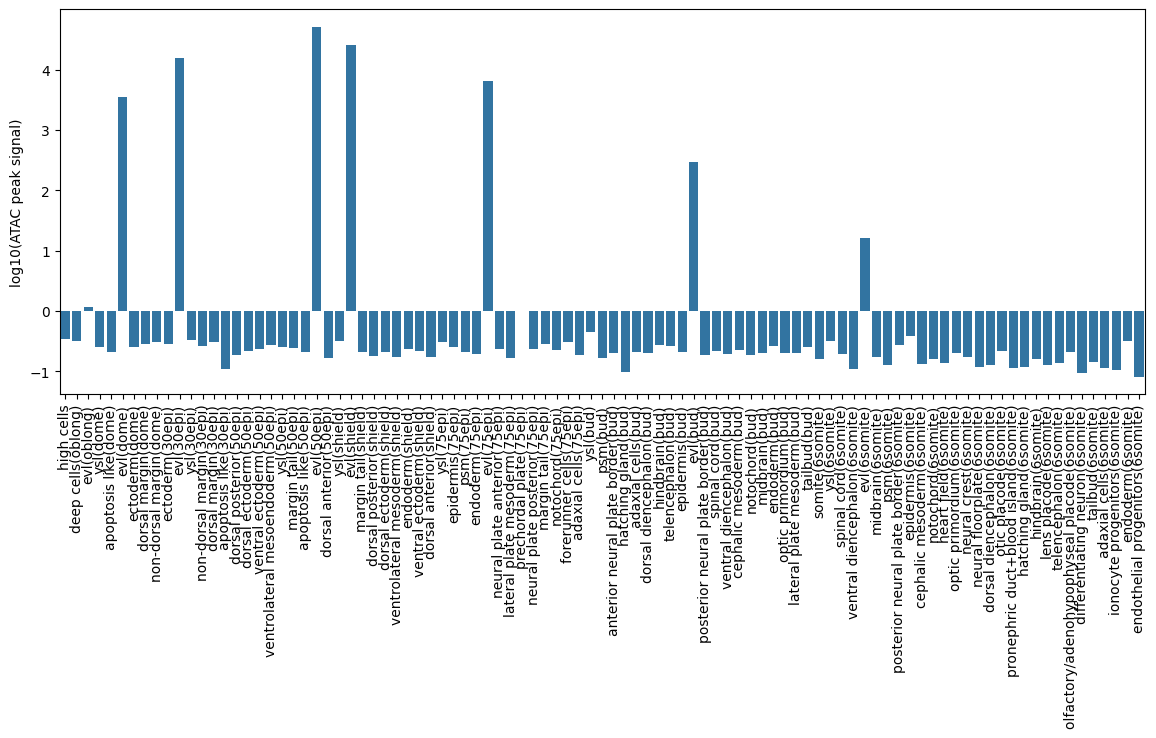

In [8]:
# Plot predictions
fig, ax = pyplot.subplots(figsize=(14, 5))
seaborn.barplot(
    x=cell_states,
    y=preds[0],
    ax=ax,
)
ax.set_xticklabels(cell_states, rotation=90)
ax.set_ylabel('log10(ATAC peak signal)')